# Sea Surface Altimetry Data Analysis

Example on using the gridded sea-surface altimetry data from The Copernicus Marine Environment

http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047

This is a widely used dataset in physical oceanography and climate.

![globe image](http://marine.copernicus.eu/documents/IMG/SEALEVEL_GLO_SLA_MAP_L4_REP_OBSERVATIONS_008_027.png)

The dataset has already been extracted from copernicus and stored in google cloud storage in [xarray-zarr](http://xarray.pydata.org/en/latest/io.html#zarr) format.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gcsfs
plt.rcParams['figure.figsize'] = (15,10)
%matplotlib inline

### Initialize Dataset

Here we load the dataset from the zarr store. Note that this very large dataset initializes nearly instantly, and we can see the full list of variables and coordinates.

In [2]:
gcsmap = gcsfs.mapping.GCSMap('pangeo-data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3-alt')
ds = xr.open_zarr(gcsmap)
ds

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<shape=(8901, 720, 2), chunksize=(5, 720, 2)>
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
    lon_bnds   (longitude, nv) float32 dask.array<shape=(1440, 2), chunksize=(1440, 2)>
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    err        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    sla        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    ugos       (time, latitude, longitude) float64 dask.array<shape=(890

### Examine Metadata

For those unfamiliar with this dataset, the variable metadata is very helpful for understanding what the variables actually represent

In [3]:
for v in ds.data_vars:
    print('{:>10}: {}'.format(v, ds[v].attrs['long_name']))

       adt: Absolute dynamic topography
       err: Formal mapping error
       sla: Sea level anomaly
      ugos: Absolute geostrophic velocity: zonal component
     ugosa: Geostrophic velocity anomalies: zonal component
      vgos: Absolute geostrophic velocity: meridian component
     vgosa: Geostrophic velocity anomalies: meridian component


### Create and Connect to Dask Distributed Cluster

In [4]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=20)
cluster

** ☝️ Don't forget to click the link above to view the scheduler dashboard! **

In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://10.21.61.9:44494 Dashboard: /user/rabernat/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 440.00 GB


## Visually Examine Some of the Data

Let's do a sanity check that the data looks reasonable:

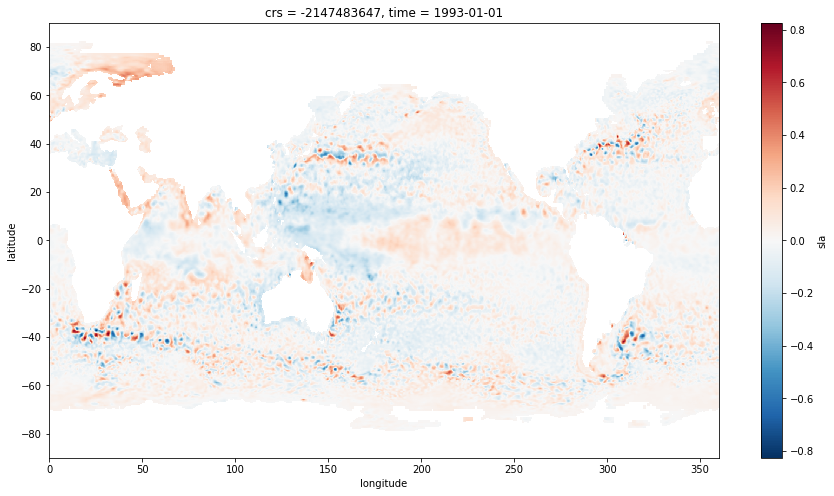

In [6]:
plt.rcParams['figure.figsize'] = (15, 8)
ds.sla.sel(time='1982-08-07', method='nearest').plot()

## Timeseries of Global Mean Sea Level

Here we make a simple yet fundamental calculation: the rate of increase of global mean sea level over the observational period.

In [7]:
# the number of GB involved in the reduction
ds.sla.nbytes/1e9

73.8284544

In [8]:
# the computationally intensive step
sla_timeseries = ds.sla.mean(dim=('latitude', 'longitude')).load()

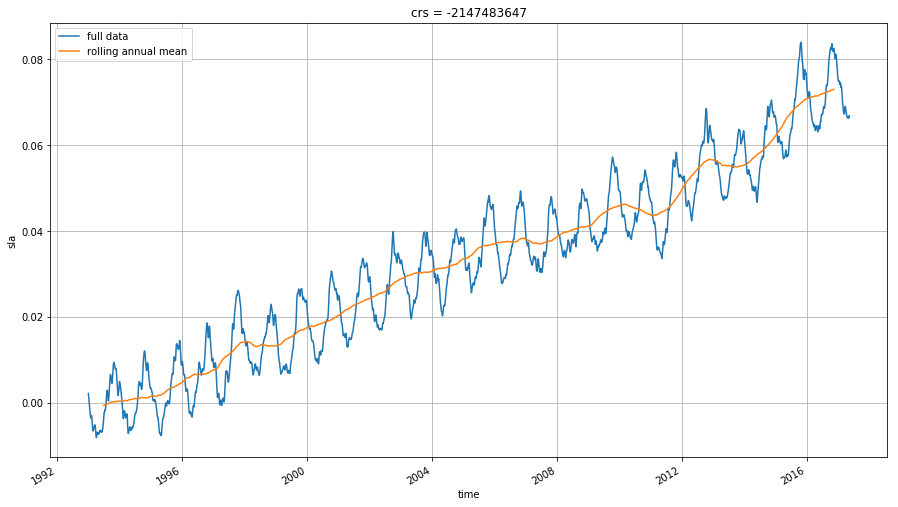

In [9]:
sla_timeseries.plot(label='full data')
sla_timeseries.rolling(time=365, center=True).mean().plot(label='rolling annual mean')
plt.legend()
plt.grid()

Astute readers will note that this global mean is biased because the pixels were averaged naively, neglecting the spherical geometry of Earth. Below we repeat with a proper a weighing factor based on cosine of latitude.

In [11]:
coslat = np.cos(np.deg2rad(ds.latitude)).where(~ds.sla.isnull())
weights = coslat / coslat.sum(dim=('latitude', 'longitude'))
sla_timeseries_weighted = (ds.sla * weights).sum(dim=('latitude', 'longitude'))
sla_timeseries_weighted.load()

<xarray.DataArray (time: 8901)>
array([-0.000846, -0.00104 , -0.001204, ...,  0.070539,  0.070415,  0.070242])
Coordinates:
    crs      int32 -2147483647
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...

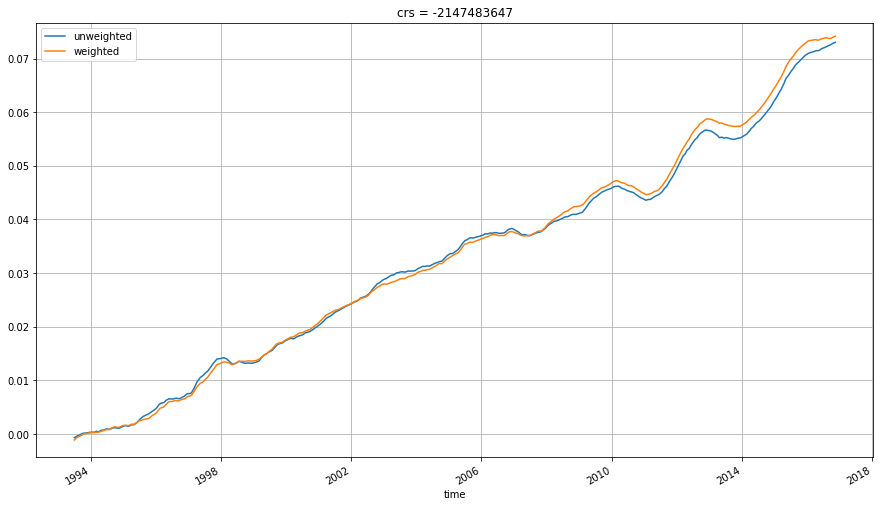

In [12]:
sla_timeseries.rolling(time=365, center=True).mean().plot(label='unweighted')
sla_timeseries_weighted.rolling(time=365, center=True).mean().plot(label='weighted')
plt.legend()
plt.grid()

In this case, the weighting actually didn't make much difference!

In order to understand how the sea level rise is distributed in latitude, we can make a sort of [Hovmöller diagram](https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram).

In [13]:
sla_hov = ds.sla.mean(dim='longitude').load()

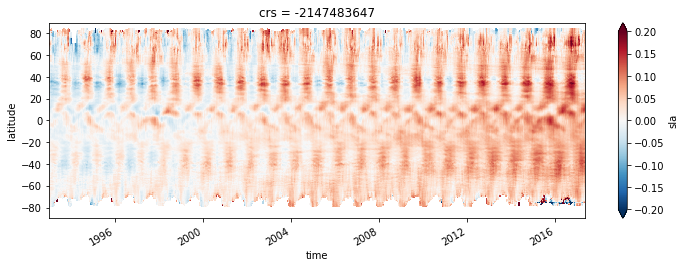

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
sla_hov.transpose().plot(vmax=0.2, ax=ax)

We can see that most sea level rise is actually in the Southern Hemisphere.

## Sea Level Variability

We can quantify the natural variability in sea level by looking at its standard deviation in time.
(We have not bothered to remove the trend; in this case, the trend is much smaller than the interannual variability.)

In [15]:
sla_std = ds.sla.std(dim='time').load()

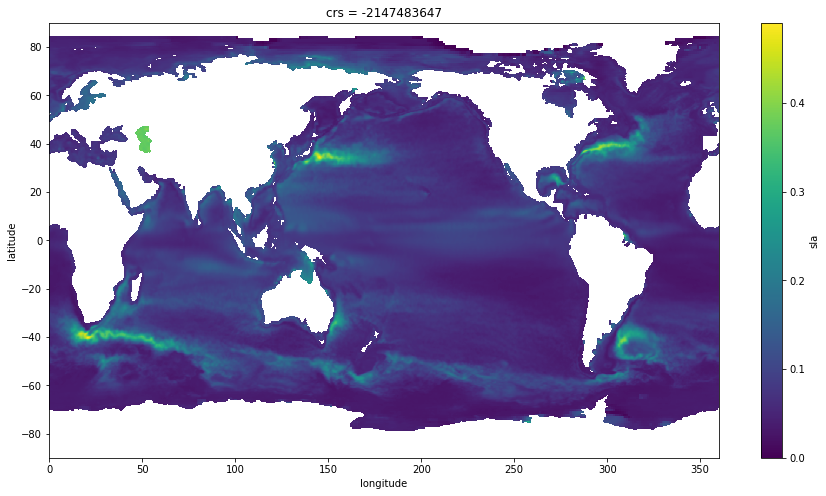

In [16]:
sla_std.plot()